In [1]:
import tensorflow as tf
import tensorflow.contrib.timeseries as ts
import multiprocessing
import pandas as pd
import numpy as np
import shutil
from datetime import datetime
import matplotlib.pyplot as plt
#%matplotlib inline

print(tf.__version__)

/Users/khalidsalama/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


1.4.0


In [2]:
MODEL_NAME = 'ts-model-01'

TRAIN_DATA_FILE = 'data/train-data.csv'
TEST_DATA_FILE = 'data/test-data.csv'

RESUME_TRAINING = False
MULTI_THREADING = True

# Steps to use the ARRegressor Estimator API
1. Define the **metadata**
2. Define a data (Numpy) **input function**
3. Define a **create Estimator** function
4. Instantiate an esimator with the **run_config and required params**
5. **Train** the estimaor
6. **Evaluate** the estimator
7. **Predict** using the estimator

## 1. Define Metadata

In [3]:
HEADER = ['time_index','value']
TIME_INDEX_FEATURE_NAME = 'time_index'
VALUE_FEATURE_NAMES = ['value']

## 2. Define a Data Input Function

In [4]:
def generate_input_fn(file_name, mode, header_lines=1, batch_size = None, windows_size = None, tail_count=None):
    
    dataframe = pd.read_csv(file_name, names=HEADER, skiprows=header_lines)
    

    if tail_count is not None:
        dataframe = dataframe.tail(tail_count)
    
    print("Dataset Size: {}".format(len(dataframe)))
    print("")
    
    
    data = {
        ts.TrainEvalFeatures.TIMES: dataframe[TIME_INDEX_FEATURE_NAME],
        ts.TrainEvalFeatures.VALUES: dataframe[VALUE_FEATURE_NAMES],
    }
    
    reader = ts.NumpyReader(data)
    
    num_threads = multiprocessing.cpu_count() if MULTI_THREADING else 1
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        input_fn = tf.contrib.timeseries.RandomWindowInputFn(
            reader, 
            batch_size=batch_size, 
            window_size=windows_size,
            num_threads= num_threads
        )
        
    elif mode == tf.estimator.ModeKeys.EVAL:
        input_fn = tf.contrib.timeseries.WholeDatasetInputFn(reader)
    
    return input_fn

## 3. Define a Create Estimator Function

In [5]:
def create_estimator(run_config, hparams):

    estimator = ts.ARRegressor(
        periodicities= hparams.periodicities, 
        input_window_size= hparams.input_window_size, 
        output_window_size= hparams.output_window_size,
        num_features=len(VALUE_FEATURE_NAMES),
        loss=hparams.loss,
        hidden_layer_sizes = hparams.hidden_units,
        optimizer = tf.train.AdagradOptimizer(learning_rate=hparams.learning_rate),
        config=run_config
    )
    
    print("")
    print("Estimator Type: {}".format(type(estimator)))
    print("")

    return estimator

## 4. Instantiate and Estimator with the Required Parameters

In [6]:
CHECKPOINT_STEPS=1000

hparams  = tf.contrib.training.HParams(
    training_steps = 10000,
    periodicities = [200],
    input_window_size = 40,
    output_window_size=10,
    batch_size = 15,
    loss = tf.contrib.timeseries.ARModel.NORMAL_LIKELIHOOD_LOSS, # NORMAL_LIKELIHOOD_LOSS | SQUARED_LOSS
    hidden_units = None,
    learning_rate = 0.1
    
)


model_dir = 'trained_models/{}'.format(MODEL_NAME)

run_config = tf.estimator.RunConfig().replace(
    save_checkpoints_steps=CHECKPOINT_STEPS,
    tf_random_seed=19830610,
    model_dir=model_dir
)
                                             
print("Model directory: {}".format(run_config.model_dir))
print("Hyper-parameters: {}".format(hparams))
print("")

train_input_fn = generate_input_fn(
    file_name=TRAIN_DATA_FILE,
    mode = tf.estimator.ModeKeys.TRAIN,
    batch_size=hparams.batch_size,
    windows_size = hparams.input_window_size + hparams.output_window_size
)

estimator = create_estimator(run_config, hparams)

Model directory: trained_models/ts-model-01
Hyper-parameters: [('batch_size', 15), ('hidden_units', None), ('input_window_size', 40), ('learning_rate', 0.1), ('loss', 'normal_likelihood_loss'), ('output_window_size', 10), ('periodicities', [200]), ('training_steps', 10000)]

Dataset Size: 700

INFO:tensorflow:Using config: {'_model_dir': 'trained_models/ts-model-01', '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x125fb5ac8>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Estimator Type: <class 'tensorflow.contrib.timeseries.python.timeseries.estimators.ARRegressor'>



## 5. Train the Estimator

In [7]:
if not RESUME_TRAINING:
    shutil.rmtree(model_dir, ignore_errors=True)
    
tf.logging.set_verbosity(tf.logging.INFO)

time_start = datetime.utcnow() 
print("Estimator training started at {}".format(time_start.strftime("%H:%M:%S")))
print(".......................................")

estimator.train(input_fn=train_input_fn, steps=hparams.training_steps)

time_end = datetime.utcnow() 
print(".......................................")
print("Estimator training finished at {}".format(time_end.strftime("%H:%M:%S")))
print("")
time_elapsed = time_end - time_start
print("Estimator training elapsed time: {} seconds".format(time_elapsed.total_seconds()))

Estimator training started at 18:14:08
.......................................
Instructions for updating:
Please switch to tf.train.get_global_step
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into trained_models/ts-model-01/model.ckpt.
INFO:tensorflow:loss = 1.66503, step = 1
INFO:tensorflow:global_step/sec: 543.585
INFO:tensorflow:loss = 0.850968, step = 101 (0.187 sec)
INFO:tensorflow:global_step/sec: 731.17
INFO:tensorflow:loss = 0.649927, step = 201 (0.138 sec)
INFO:tensorflow:global_step/sec: 684.665
INFO:tensorflow:loss = 0.487094, step = 301 (0.145 sec)
INFO:tensorflow:global_step/sec: 833.445
INFO:tensorflow:loss = 0.569605, step = 401 (0.120 sec)
INFO:tensorflow:global_step/sec: 623.916
INFO:tensorflow:loss = 0.460963, step = 501 (0.159 sec)
INFO:tensorflow:global_step/sec: 597.425
INFO:tensorflow:loss = 0.502778, step = 601 (0.168 sec)
INFO:tensorflow:global_step/sec: 470.979
INFO:tensorflow:loss = 0.493022, step = 701 (0.212 sec)
INFO

INFO:tensorflow:global_step/sec: 325.071
INFO:tensorflow:loss = 0.027012, step = 7301 (0.308 sec)
INFO:tensorflow:global_step/sec: 269.127
INFO:tensorflow:loss = 0.0512254, step = 7401 (0.371 sec)
INFO:tensorflow:global_step/sec: 320.375
INFO:tensorflow:loss = 0.232202, step = 7501 (0.312 sec)
INFO:tensorflow:global_step/sec: 328.149
INFO:tensorflow:loss = 0.311213, step = 7601 (0.305 sec)
INFO:tensorflow:global_step/sec: 334.126
INFO:tensorflow:loss = 0.130004, step = 7701 (0.300 sec)
INFO:tensorflow:global_step/sec: 323.778
INFO:tensorflow:loss = 0.232519, step = 7801 (0.309 sec)
INFO:tensorflow:global_step/sec: 344.553
INFO:tensorflow:loss = 0.277928, step = 7901 (0.289 sec)
INFO:tensorflow:Saving checkpoints for 8001 into trained_models/ts-model-01/model.ckpt.
INFO:tensorflow:global_step/sec: 92.4579
INFO:tensorflow:loss = 0.206559, step = 8001 (1.081 sec)
INFO:tensorflow:global_step/sec: 745.307
INFO:tensorflow:loss = 0.119412, step = 8101 (0.135 sec)
INFO:tensorflow:global_step/s

## 6. Evalute the Estimator

In [8]:
hparams  = tf.contrib.training.HParams(
    training_steps = 10000,
    periodicities = [200],
    input_window_size = 40,
    output_window_size=10,
    batch_size = 15,
    loss = tf.contrib.timeseries.ARModel.SQUARED_LOSS, # NORMAL_LIKELIHOOD_LOSS | SQUARED_LOSS
    hidden_units = None,
    learning_rate = 0.1
    
)

estimator = create_estimator(run_config, hparams)

eval_input_fn = generate_input_fn(
    file_name=TRAIN_DATA_FILE,
    mode = tf.estimator.ModeKeys.EVAL,
)

tf.logging.set_verbosity(tf.logging.WARN)
evaluation = estimator.evaluate(input_fn=eval_input_fn, steps=1)
print("")
print(evaluation.keys())
print("")
print("Evaluation Loss ({}) : {}".format(hparams.loss, evaluation['loss']))

INFO:tensorflow:Using config: {'_model_dir': 'trained_models/ts-model-01', '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x125fb5ac8>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Estimator Type: <class 'tensorflow.contrib.timeseries.python.timeseries.estimators.ARRegressor'>

Dataset Size: 700


dict_keys(['covariance', 'loss', 'mean', 'observed', 'start_tuple', 'times', 'global_step'])

Evaluation Loss (squared_loss) : 0.19893397390842438


In [9]:
def compute_rmse(a, b):
    rmse =  np.sqrt(np.sum(np.square(a - b)) / len(a))
    return round(rmse,5)

def compute_mae(a, b):
    mae =  np.sqrt(np.sum(np.abs(a - b)) / len(a))
    return round(mae,5)

In [10]:
x_current = evaluation['times'][0]
y_current_actual = evaluation['observed'][0].reshape(-1)
y_current_estimated = evaluation['mean'][0].reshape(-1)

rmse = compute_rmse(y_current_actual, y_current_estimated)
mae = compute_mae(y_current_actual, y_current_estimated)
print("Evaluation RMSE {}".format(rmse))
print("Evaluation MAE {}".format(mae))

Evaluation RMSE 0.44602
Evaluation MAE 0.58438


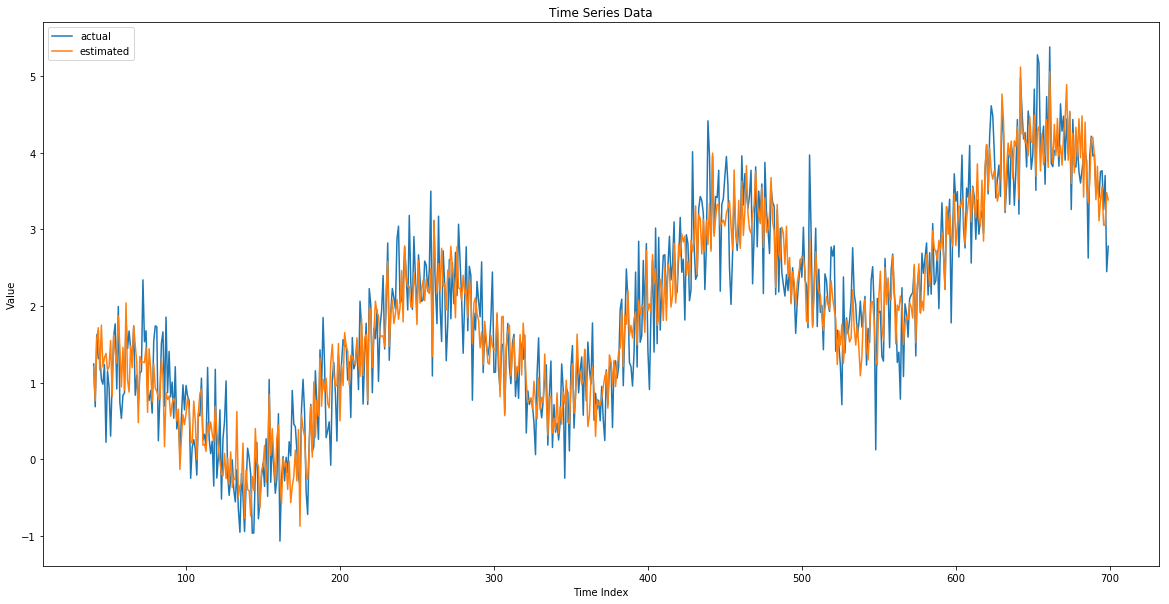

In [11]:
plt.figure(figsize=(20, 10))

plt.title("Time Series Data")
plt.plot(x_current, y_current_actual, label='actual')
plt.plot(x_current, y_current_estimated, label='estimated')
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend(loc=2)
plt.show()

## 7. Predict using the Estimator

In [12]:
FORECAST_STEPS = [10,50,100,150,200,250,300]

tf.logging.set_verbosity(tf.logging.ERROR)

eval_input_fn = generate_input_fn(
    file_name=TRAIN_DATA_FILE,
    mode = tf.estimator.ModeKeys.EVAL,
    tail_count = hparams.input_window_size + hparams.output_window_size
)


evaluation = estimator.evaluate(input_fn=eval_input_fn, steps=1)

df_test = pd.read_csv(TEST_DATA_FILE, names=['time_index','value'], header=0)
print("Test Dataset Size: {}".format(len(df_test)))
print("")

for steps in FORECAST_STEPS:

    forecasts = estimator.predict(input_fn=ts.predict_continuation_input_fn(evaluation, steps=steps))
    forecasts = tuple(forecasts)[0]
    
    x_next = forecasts['times']
    
    y_next_forecast = forecasts['mean']
    y_next_actual = df_test.value[:steps].values
    
    rmse =  compute_rmse(y_next_actual, y_next_forecast)
    mae =  compute_mae(y_next_actual, y_next_forecast)

    print("Forecast Steps {}: RMSE {} - MAE {}".format(steps,rmse,mae))

print("")
print(forecasts.keys())

Dataset Size: 50

Test Dataset Size: 300

Forecast Steps 10: RMSE 2.15341 - MAE 2.34381
Forecast Steps 50: RMSE 4.85698 - MAE 5.30662
Forecast Steps 100: RMSE 7.76817 - MAE 7.88263
Forecast Steps 150: RMSE 16.45679 - MAE 12.72724
Forecast Steps 200: RMSE 20.7832 - MAE 15.48061
Forecast Steps 250: RMSE 21.42506 - MAE 16.60133
Forecast Steps 300: RMSE 22.28004 - MAE 17.69507

dict_keys(['mean', 'covariance', 'times'])


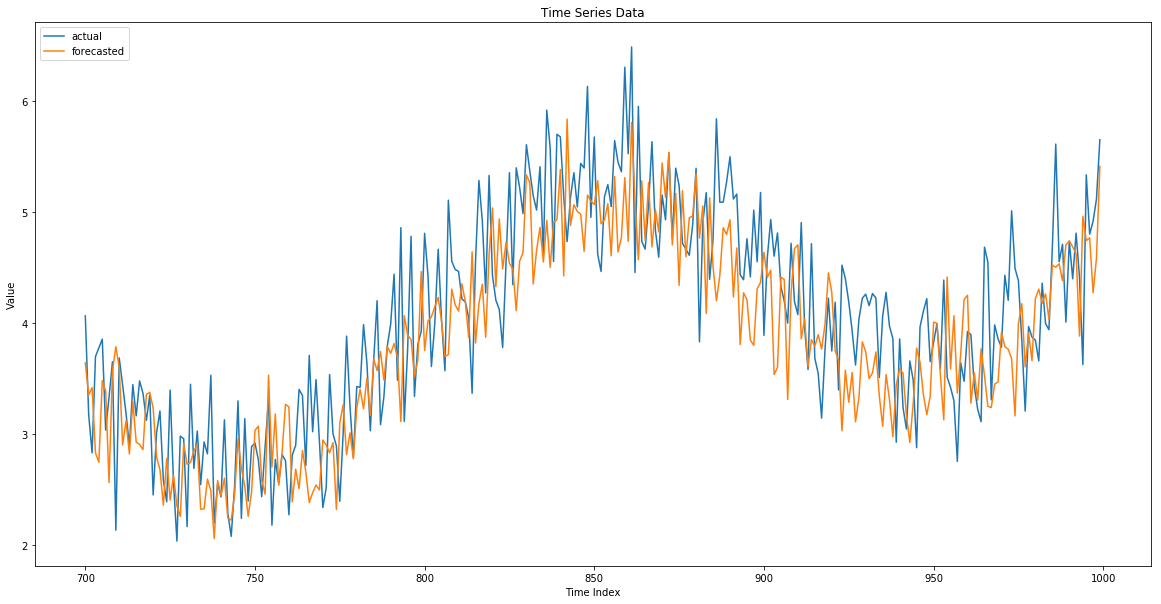

In [13]:
plt.close('all')
plt.figure(figsize=(20, 10))

plt.title("Time Series Data")
plt.plot(x_next, y_next_actual, label='actual')
plt.plot(x_next, y_next_forecast, label='forecasted')
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend(loc=2)
plt.show()

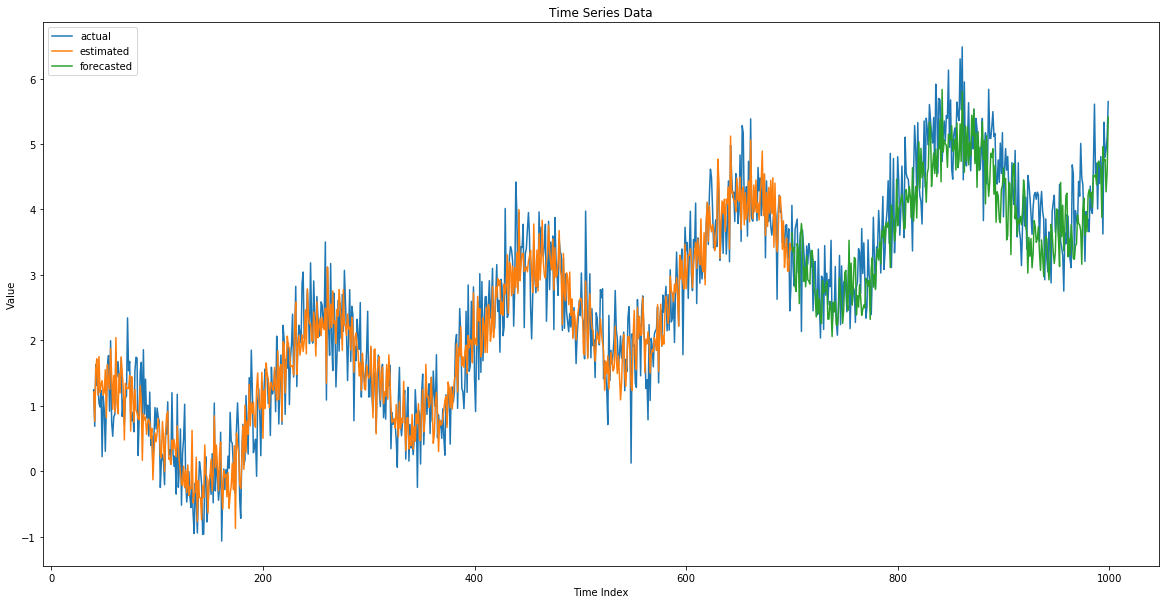

In [14]:
x_all = np.concatenate( (x_current, x_next) , axis=0)
y_actual_all = np.concatenate((y_current_actual, y_next_actual), axis=0)

plt.close('all')
plt.figure(figsize=(20, 10))

plt.title("Time Series Data")
plt.plot(x_all, y_actual_all, label='actual')
plt.plot(x_current, y_current_estimated, label='estimated')
plt.plot(x_next, y_next_forecast, label='forecasted')
plt.xlabel("Time Index")
plt.ylabel("Value")
plt.legend(loc=2)
plt.show()

### Questions:
1. how to create a serving function and save the model?
2. forecast errror range?